In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# Open training data in nb `40.`

In [81]:
with open(f'{PATH}/results/confidence/PCA-model_train_acts-a40.pkl', 'rb') as f:
    pca = pickle.load(f)

train_acts_PCA = np.load(f'{PATH}/results/confidence/train_acts_PCA-a40.npy', )

xg_acts_PCA = np.load(f'{PATH}/results/confidence/acts_PCA-xGASS.npy',)

In [7]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

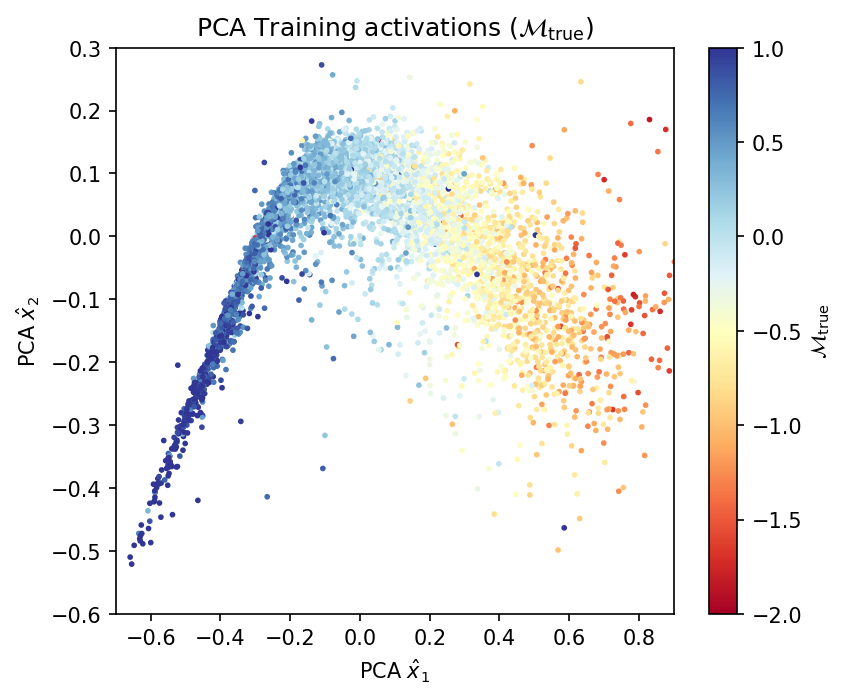

In [80]:
plt.figure(figsize=(6, 5), dpi=150)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c=data.train_ds.y.items, vmin=-2, vmax=1, s=3, cmap='RdYlBu')

cb = plt.colorbar()

plt.title(f'PCA Training activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


In [82]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

data_xg = (
        ImageList.from_df(
            xg, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
        )
        .split_none()
        .label_from_df(cols=["lgGF"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)


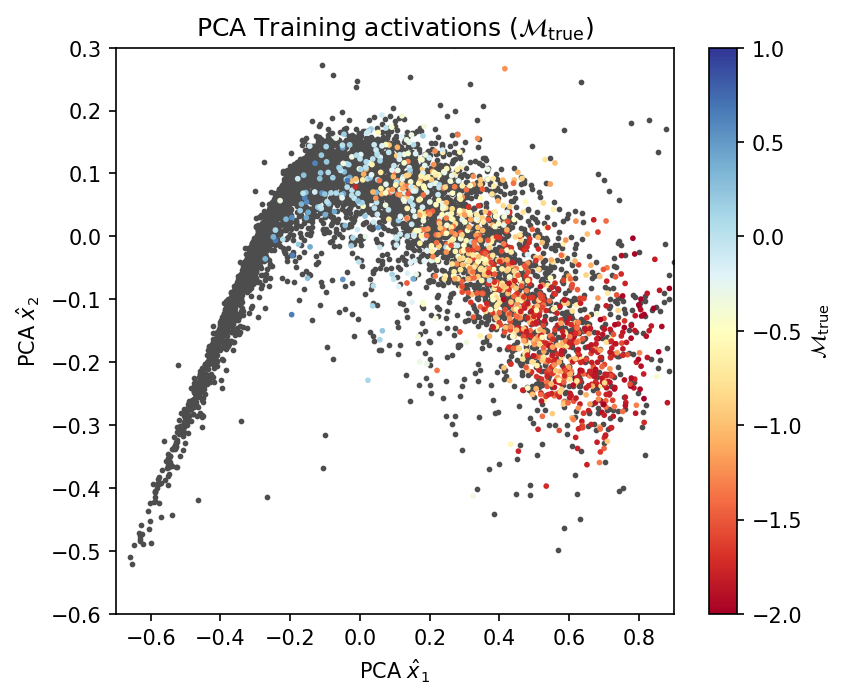

In [84]:
plt.figure(figsize=(6, 5), dpi=150)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', vmin=-2, vmax=1, s=3)

plt.scatter(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], c=data_xg.train_ds.y.items, vmin=-2, vmax=1, s=3, cmap='RdYlBu')

cb = plt.colorbar()

plt.title(f'PCA Training activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


# Visualizing images for ALFALFA

In [9]:
def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

In [27]:
acts = pd.DataFrame(
    {
        'fgas': data.train_ds.y.items, 
        'pca_1': train_acts_PCA[:, 0], 
        'pca_2': train_acts_PCA[:, 1],
        'fname': data.train_ds.items,
    },
)

In [28]:
acts.sample(3)

,fgas,pca_1,pca_2,fname
2895,-0.135486,-0.098936,0.111504,/home/jupyter/alfalfa-convnets/images-OC/22031...
4802,0.145690,0.075664,0.091108,/home/jupyter/alfalfa-convnets/images-OC/24497...
3325,0.200690,0.126705,0.064094,/home/jupyter/alfalfa-convnets/images-OC/22106...


## Gas-rich ALFALFA galaxies

In [74]:
subset = acts[(acts.pca_1 < -0.5) & (acts.pca_2 < -0.4)]

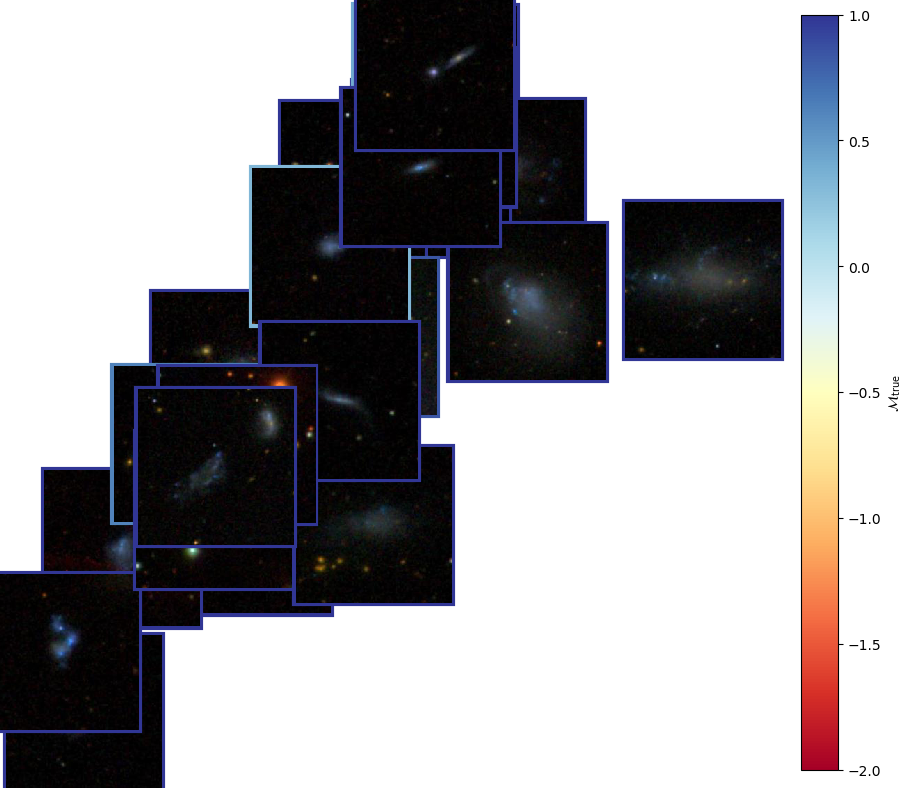

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(subset.pca_1, subset.pca_2, c=subset.fgas, 
           vmin=-2, vmax=1, cmap='RdYlBu')


# plt.title('PCA of final conv layer (colored by gas mass fraction)', fontsize=18)

artists = []
for _, [lgGF, x, y, fname] in subset.iterrows():
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.5), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF/3+2/3)))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')
    
plt.colorbar(sc, label=r'$\mathcal{M}_{\rm true}$')

## Normal star-forming galaxies

In [67]:
subset = acts[(acts.pca_1 < 0) & (acts.pca_1 > -0.05) & (acts.pca_2 > 0.02) & (acts.pca_2 < 0.07)]
len(subset)

48

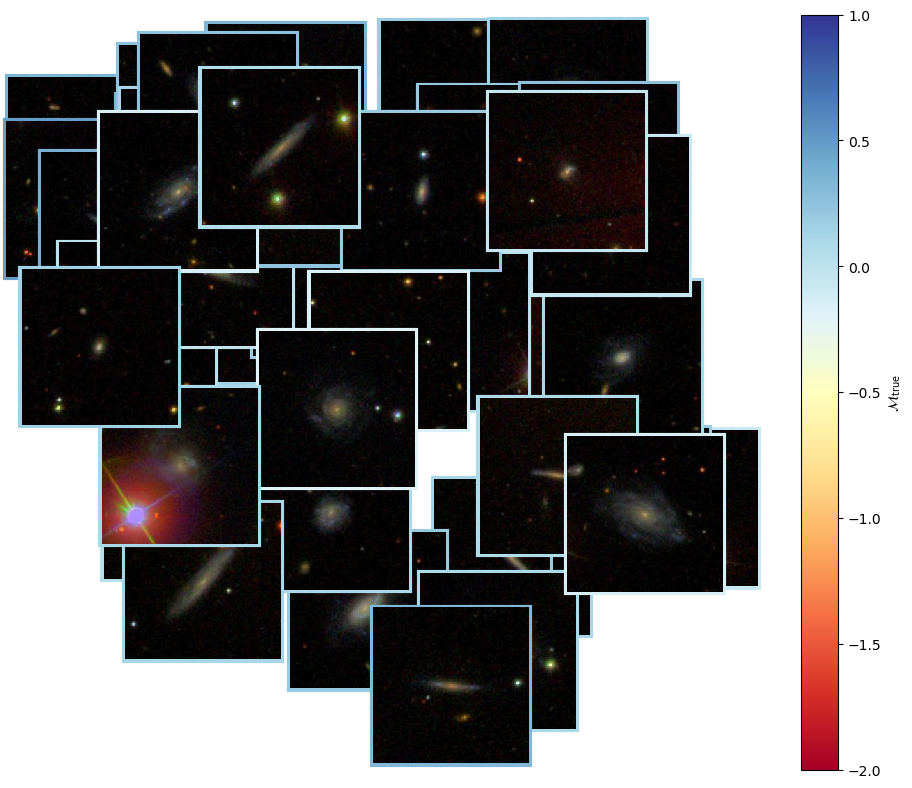

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(subset.pca_1, subset.pca_2, c=subset.fgas, 
           vmin=-2, vmax=1, cmap='RdYlBu')

artists = []
for _, [lgGF, x, y, fname] in subset.iterrows():
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.5), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF/3+2/3)))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')
    
plt.colorbar(sc, label=r'$\mathcal{M}_{\rm true}$')

## Gas-poor galaxies

In [72]:
subset = acts[(acts.pca_1 < 0.5) & (acts.pca_1 > 0.4) & (acts.pca_2 > -0.2) & (acts.pca_2 < -0.1)]
len(subset)

90

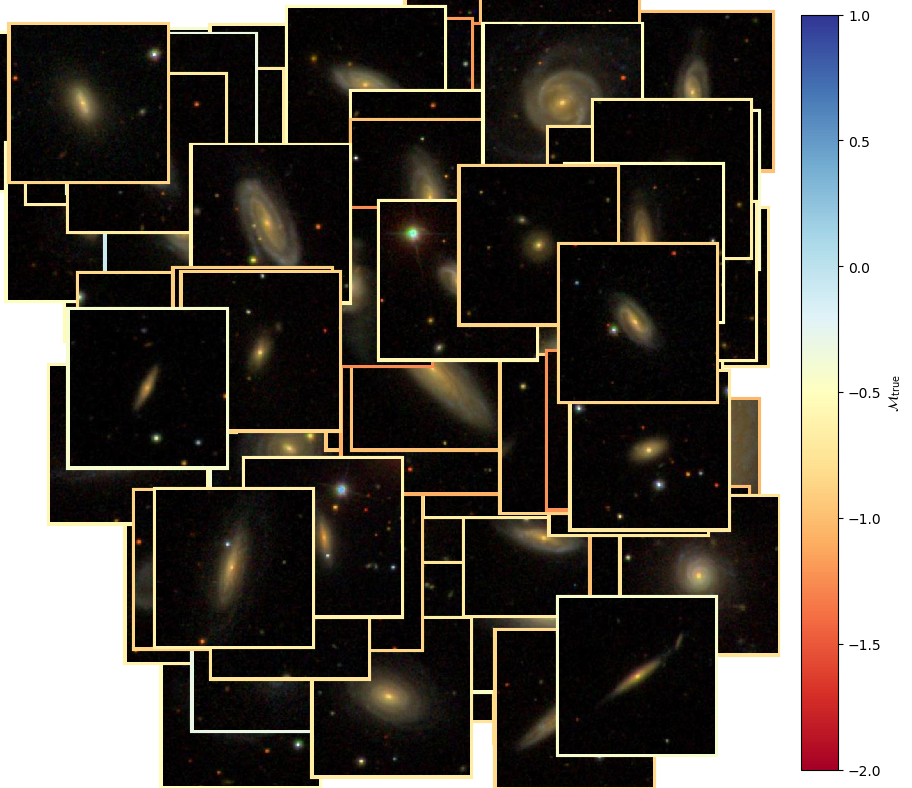

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(subset.pca_1, subset.pca_2, c=subset.fgas, 
           vmin=-2, vmax=1, cmap='RdYlBu')



artists = []
for _, [lgGF, x, y, fname] in subset.iterrows():
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.5), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF/3+2/3)))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')
    
plt.colorbar(sc, label=r'$\mathcal{M}_{\rm true}$')

# Visualizing images for xGASS

In [85]:
acts_xg = pd.DataFrame(
    {
        'fgas': data_xg.train_ds.y.items, 
        'pca_1': xg_acts_PCA[:, 0], 
        'pca_2': xg_acts_PCA[:, 1],
        'fname': data_xg.train_ds.items,
    },
)

## Normal star-forming galaxies

In [95]:
subset_xg = acts_xg[(acts_xg.pca_1 < 0) & (acts_xg.pca_1 > -0.1) & (acts_xg.pca_2 > 0.) & (acts_xg.pca_2 < 0.1)]
len(subset_xg)

26

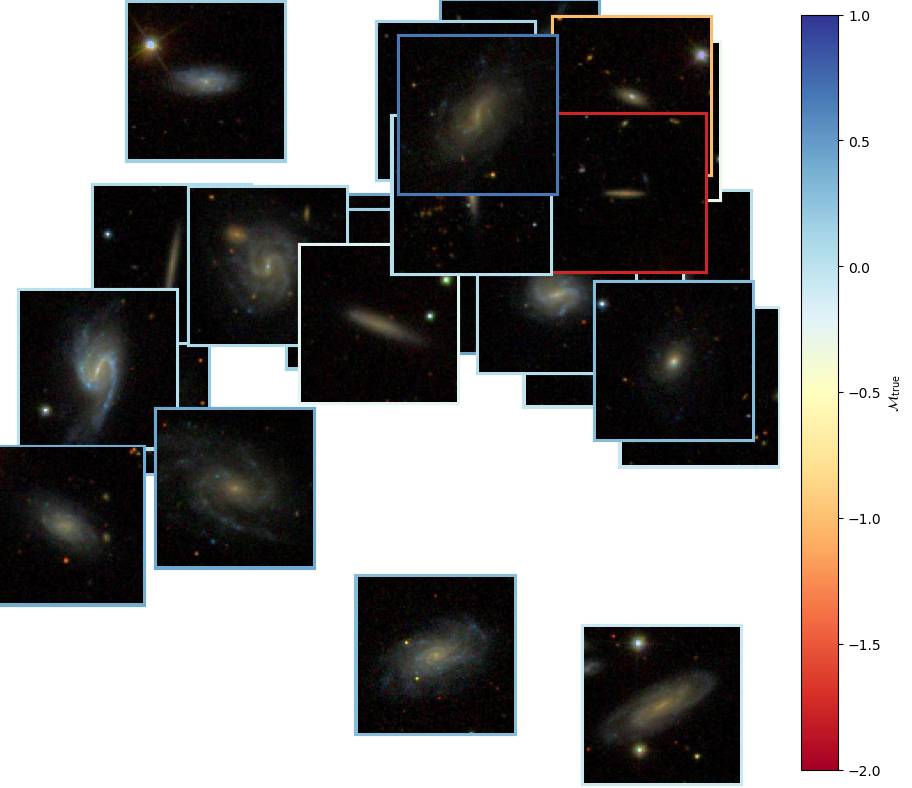

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=100)

sc = ax.scatter(subset_xg.pca_1, subset_xg.pca_2, c=subset_xg.fgas, 
           vmin=-2, vmax=1, cmap='RdYlBu')

artists = []
for _, [lgGF, x, y, fname] in subset_xg.iterrows():
    ab = AnnotationBbox(
        OffsetImage(image2np(open_image(fname).data), zoom=0.5), 
        (x, y), 
        xycoords='data', 
        frameon=True, 
        pad=0.1, 
        bboxprops=dict(linewidth=3, edgecolor=plt.cm.RdYlBu((lgGF/3+2/3)))
    )
    artists.append(ax.add_artist(ab))
plt.axis('off')
    
plt.colorbar(sc, label=r'$\mathcal{M}_{\rm true}$')

## Gas-poor galaxies

In [97]:
subset_xg = acts_xg[(acts_xg.pca_1 < 0.5) & (acts_xg.pca_1 > 0.4) & (acts_xg.pca_2 > -0.2) & (acts_xg.pca_2 < -0.1)]
len(subset_xg)

74